# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 21.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0


In [3]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [4]:
 os.listdir('.')

['data',
 'validation_annotation',
 'train',
 'train_annotation',
 'images.tar.gz',
 'validation',
 'DejaVuSerif-Bold.ttf',
 '.sparkmagic',
 'Sagemaker Object Detection - Learner Notebook.ipynb',
 'annotations.tar.gz',
 'lost+found',
 '.ipynb_checkpoints']

# Extracting Annotations from XML Format

In [5]:
xml_dir = 'data/annotations/xmls/'
xml_files = [os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x[-3:] == 'xml']
xml_files[0]

'data/annotations/xmls/scottish_terrier_10.xml'

In [6]:
classes = ['cat', 'dog']
categories = [
    {
        'class_id': 0,
        'name': 'cat'
    },
    {
        'class_id': 1,
        'name': 'dog'
    }
]

In [7]:
# Load the XML file
tree = ET.parse(xml_files[0])
root = tree.getroot()

# Define a function to print XML element, its text content, and children recursively
def print_xml_element(element, indent=0):
    if element.text and element.text.strip():
        print(' ' * indent + element.tag + ': ' + element.text.strip())
    else:
        print(' ' * indent + element.tag)
        
    for child in element:
        print_xml_element(child, indent + 2)

# Print the XML structure
print_xml_element(root)

annotation
  folder: OXIIIT
  filename: scottish_terrier_10.jpg
  source
    database: OXFORD-IIIT Pet Dataset
    annotation: OXIIIT
    image: flickr
  size
    width: 500
    height: 335
    depth: 3
  segmented: 0
  object
    name: dog
    pose: Frontal
    truncated: 0
    occluded: 0
    bndbox
      xmin: 24
      ymin: 11
      xmax: 125
      ymax: 186
    difficult: 0


In [8]:
def extract_annotation(xml_file_path):
    
    # Load the XML file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotation = {}
    
    annotation['file'] = root.find('filename').text
    annotation['categories'] = categories
    
    size = root.find('size')
    
    annotation['image_size'] = [{
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }]
    
    annotation['annotations'] = []
    
    for item in root.iter('object'):
        class_id = classes.index(item.find('name').text)
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in item.findall('bndbox'):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
        
            if all([xmin, ymin, xmax, ymax]) is not None:
                 annotation['annotations'].append({
                     'class_id': class_id,
                     'left': xmin,
                     'top': ymin,
                     'width': xmax - xmin,
                     'height': ymax - ymin
                 })
    return annotation

In [9]:
extract_annotation(xml_files[0])

{'file': 'scottish_terrier_10.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 500, 'height': 335, 'depth': 3}],
 'annotations': [{'class_id': 1,
   'left': 24,
   'top': 11,
   'width': 101,
   'height': 175}]}

# Visualize Data

In [10]:
index = random.randint(0, len(xml_files) - 1)

In [11]:
xml_files[index]

'data/annotations/xmls/Siamese_139.xml'

In [12]:
extract_annotation(xml_files[index])

{'file': 'Siamese_139.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 333, 'height': 500, 'depth': 3}],
 'annotations': [{'class_id': 0,
   'left': 48,
   'top': 35,
   'width': 217,
   'height': 250}]}

In [13]:
def plot_example(plt, annot, image_file_path, rows, cols, index):
    img = Image.open(image_file_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('DejaVuSerif-Bold.ttf', 20)
    
    for a in annot['annotations']:
        box = [
            int(a['left']), int(a['top']),
            int(a['left']) + int(a['width']),
            int(a['top']) + int(a['height'])
        ]
        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(a['class_id'])], font=font)
    plt.subplot(rows, cols, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return plt

def show_random_annotations(plt):
    plt.figure(figsize=(16, 16))
    for i in range(0, 9):
        index = random.randint(0, len(xml_files) - 1)
        
        annot = extract_annotation(xml_files[index])
        image_file_path = os.path.join('data/images/', annot['file'])

        plt = plot_example(plt, annot, image_file_path, 3, 3, i)
    plt.show()

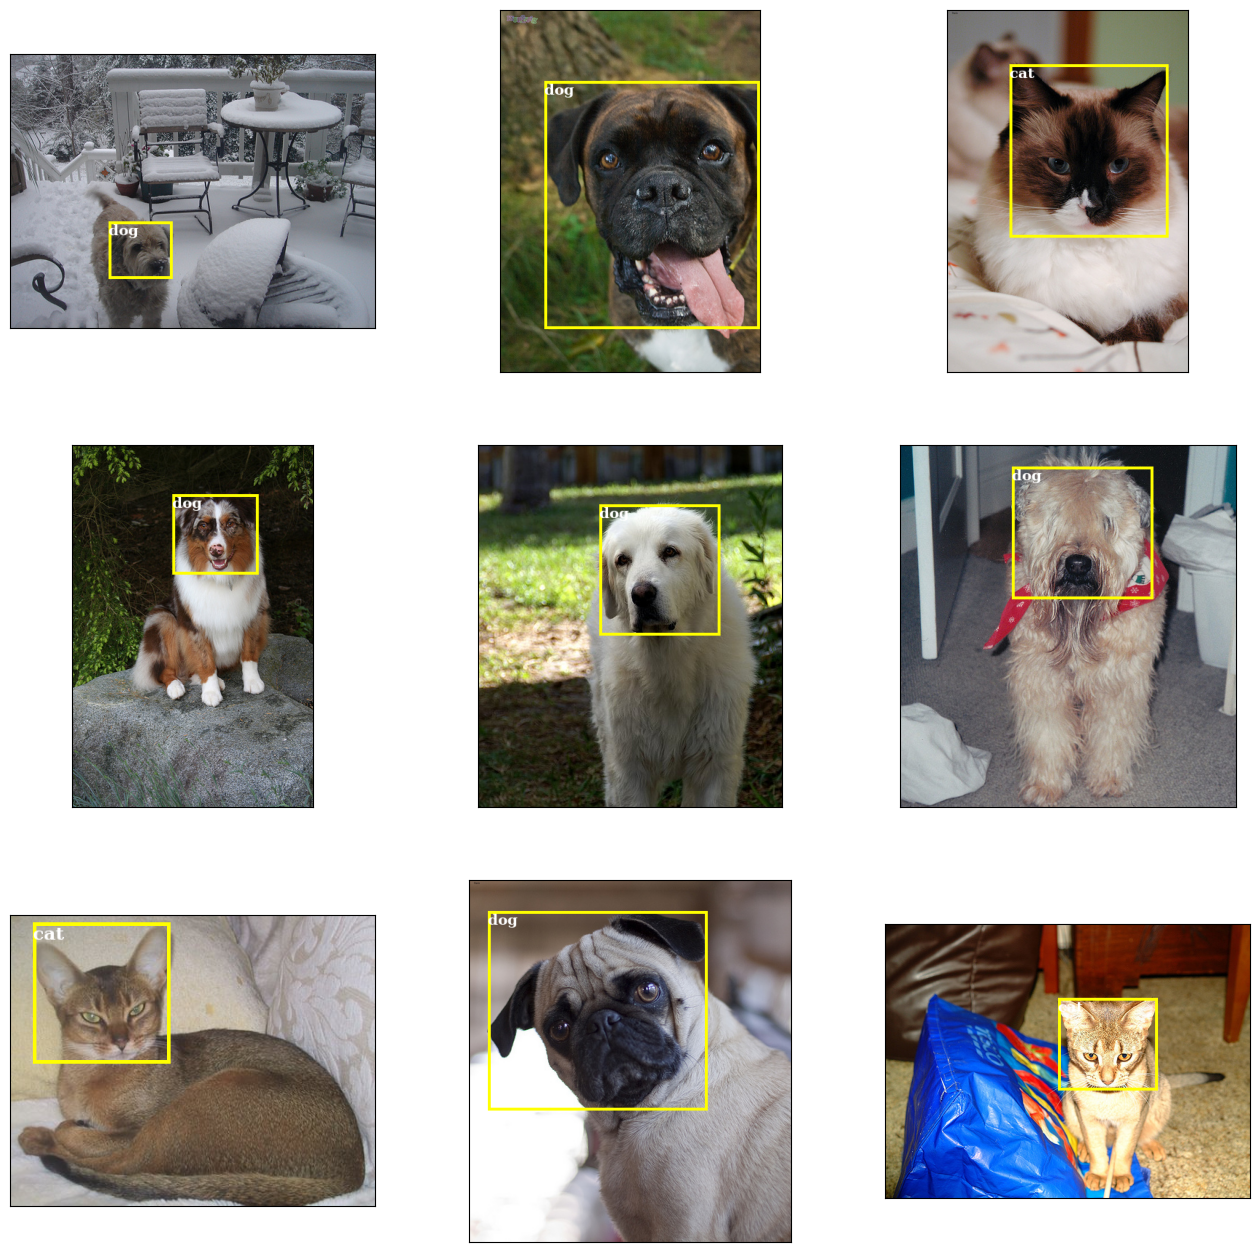

In [14]:
show_random_annotations(plt)

# SageMaker Setup

In [15]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdata-zichuan'

# get training docker image
training_image = get_image_uri(boto3.Session().region_name, 'object-detection',
                               repo_version='latest')

# print training docker image location
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:1


In [16]:
# create empty folders to store training and validation data

folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [17]:
print('Total examples:', len(xml_files))

Total examples: 3686


In [18]:
# split train validation data
# copy image to image folder
# copy annotation to annotation folder

for xml_file in tqdm(xml_files):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    annot = extract_annotation(xml_file)
    image_file_path = os.path.join('data/images/', annot['file'])
    image_target_path = os.path.join(target_set, annot['file'])
    shutil.copy(image_file_path, image_target_path) # copy images to image folder
    json_file_path = os.path.join(target_set + '_annotation', annot['file'][:-3] + 'json')
    with open(json_file_path, 'w') as f: # copy annotation to annotation folder
        json.dump(annot, f)

100%|██████████| 3686/3686 [00:07<00:00, 472.13it/s]


In [19]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [20]:
print(len(train_annots), len(train_images))

2777 2777


In [21]:
# check whether there's annotation file for each image

for image in train_images:
    key = image.split('.')[0]
    json_file = key + '.json'
    if json_file not in train_annots:
        print('Not found', json_file)

# Uploading Data to S3

In [22]:
sess = sagemaker.Session()

print('Uploading Data..')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print("Training images uploaded")
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, 
                                      key_prefix='validation')
print("Validation images uploaded")
s3_train_annotation = sess.upload_data(path='train_annotation', bucket=bucket_name, 
                                       key_prefix='train_annotation')
print("Training annotation uploaded")
s3_validation_annotation = sess.upload_data(path='validation_annotation', bucket=bucket_name, 
                                            key_prefix='validation_annotation')
print("Validationg annotation uploaded")

Uploading Data..
Training images uploaded
Validation images uploaded
Training annotation uploaded
Validationg annotation uploaded


In [23]:
s3_validation_annotation

's3://petsdata-zichuan/validation_annotation'

# SageMaker Estimator

In [24]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_type='ml.p3.2xlarge', # 16GB GPU memory
    instance_count=1,
    volume_size=100,
    max_run=36000, # seconds
    input_mode='File', # for json annotations
    output_path='s3://petsdata-zichuan/output', # train model artifacts
    sagemaker_session=sess
)

In [25]:
print(sagemaker.__version__)

2.219.0


# Hyperparameters

In [26]:
# most of these hyperparameters follows the original SSD paper

model.set_hyperparameters(
    base_network='resnet-50',
    num_classes=2,
    use_pretrained_model=1,
    mini_batch_size=16,
    epochs=15,
    learning_rate=0.001,
    optimizer='sgd',
    lr_scheduler_step='10', # '10,20' if it's comma separated then factor will be applied again
    lr_scheduler_factor=0.1, # 0.1 will be multiplied to the learning rate after 10 epochs
    momentum=0.9,
    weight_decay=0.0005,
    overlap_threshold=0.5,
    nms_threshold=0.45,
    image_shape=512,
    num_training_samples=len(train_annots)
)

# Data Channels

In [27]:
train_data = sagemaker.session.TrainingInput(
    s3_train_path,
    distribution='FullyReplicated',
    content_type='application/x-image',
    s3_data_type='S3Prefix'
)

validation_data = sagemaker.session.TrainingInput(
    s3_validation_path,
    distribution='FullyReplicated',
    content_type='application/x-image',
    s3_data_type='S3Prefix'
)

train_annotation_data = sagemaker.session.TrainingInput(
    s3_train_annotation,
    distribution='FullyReplicated',
    content_type='application/x-image',
    s3_data_type='S3Prefix'
)

validation_annotation_data = sagemaker.session.TrainingInput(
    s3_validation_annotation,
    distribution='FullyReplicated',
    content_type='application/x-image',
    s3_data_type='S3Prefix'
)

In [28]:
data_channels = {
    'train': train_data,
    'validation': validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation': validation_annotation_data
}

In [29]:
data_channels

{'train': <sagemaker.inputs.TrainingInput at 0x7f357dab50f0>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f357dab4af0>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7f357dab7b20>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7f357dab65f0>}

# Model Training

In [30]:
model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: object-detection-2024-05-25-15-07-46-537


2024-05-25 15:07:46 Starting - Starting the training job...
2024-05-25 15:08:12 Starting - Preparing the instances for training...
2024-05-25 15:08:42 Downloading - Downloading input data......
2024-05-25 15:09:42 Downloading - Downloading the training image.........
2024-05-25 15:10:53 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat May 25 15:11:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usag

# Deploy Model

In [54]:
deploy_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

INFO:sagemaker:Creating model with name: object-detection-2024-05-25-15-50-48-602
INFO:sagemaker:Creating endpoint-config with name object-detection-2024-05-25-15-50-48-602
INFO:sagemaker:Creating endpoint with name object-detection-2024-05-25-15-50-48-602


--------!
Model deployed!


# Predictions

In [55]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

909


In [56]:
deploy_model.content_type = 'image/jpeg'

In [57]:
deploy_model.endpoint_name

'object-detection-2024-05-25-15-50-48-602'

In [58]:
index = 0

# image_path = os.path.join(image_dir, images[index])
image_path = 'IMG_0474.JPG' # use an image from the internet

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deploy_model.predict(b)
results = json.loads(results)

preds = results['prediction']

In [59]:
preds[0]

[0.0,
 0.9904679656028748,
 0.41826295852661133,
 0.10200241208076477,
 0.7488588094711304,
 0.47069260478019714]

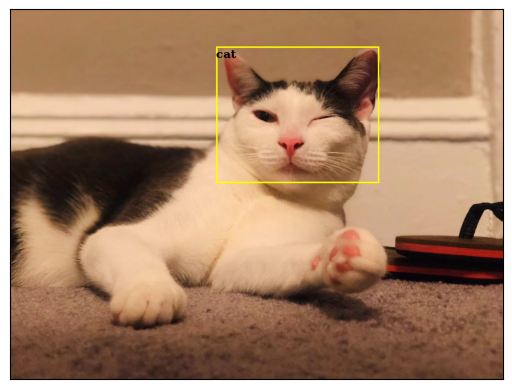

In [60]:
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('DejaVuSerif-Bold.ttf', 30)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = pred
    
    if score > 0.7:
        box = [w*xmin, h*ymin, w*xmax, h*ymax]

        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(class_id)], font=font, fill='#000000')
    else:
        break

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [61]:
sagemaker.Session().delete_endpoint(deploy_model.endpoint_name)

INFO:sagemaker:Deleting endpoint with name: object-detection-2024-05-25-15-50-48-602
